In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1605: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
fft_break = 180
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

##### We start with Microsoft's anomaly test data from here

https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

##### and then proceed to applying anomaly detection to life pump customer data


<br>

... But first let's revisit our list of anomaly functions

#### Current inventory of anomaly detectors by type


| ML Type | Type         | Detector | How does it work |
| ------- | ------------ | ------- | ---------------- |
| Unsupervised | Proximity | KMeans   | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Unsupervised | Linear Model | Generalized | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| Unsupervised | Linear Model | FFT | Run FFT before applying Generalized |
| Unsupervised | Linear Model | Spectral | Compute signal energy to reduce dimensions before applying Generalized |
| Unsupervised | Linear Model | *Saliency* | Run FFT, remove the 'averaged' parts, run inverse FFT, do generalized |
| Supervised | Outliers Ensemble | SimpleAnomaly| Run Gradient boosting on training data, anomaly if prediction deviates from actual data |



In [3]:
# Run on microsoft's anomaly data
# Get stuff in
df_i = pd.read_csv('./AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i['Temperature']=df_i['value'] + 20
df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00         23.0
       2017-10-09 20:33:00         23.0

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline

spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())])
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScore(Temperature, 12, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())])
sali._entity_type = et
df_i = sali.execute(df=df_i)

ffti = FFTbasedGeneralizedAnomalyScore(Temperature, 12, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())])
ffti._entity_type = et
df_i = ffti.execute(df=df_i)

kmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())])
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2020-01-23T12:57:24.321 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-23T12:57:24.322 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-23T12:57:25.203 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-23T12:57:25.203 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-23T12:57:26.317 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-23T12:57:26.318 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-23T12:57:27.503 WARNING iotfunctions.metadat

,Temperature,TemperatureSpectralScore,SaliencyAnomalyScore,TemperatureFFTScore,TemperatureKmeansScore
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,24.264336,-773.372364,88.306298,87.546880,0.706476
std,1.484244,15040.903131,555.808797,353.877539,1.093873
min,20.000000,-493649.655537,0.658604,-3.667584,-0.123777
25%,23.062500,19.452093,6.766033,7.970529,0.353598
50%,24.000000,22.688027,15.393861,12.775312,0.454628
75%,25.437500,23.776713,30.419237,18.940826,0.562281
max,30.750000,24.705769,11218.319761,4323.301165,7.294675


In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_i.loc[['MyRoom']]
df_input2.reset_index(level=[0], inplace=True)

Text(0, 0.5, "Saliency \n like FFT, part of Azure's approach")

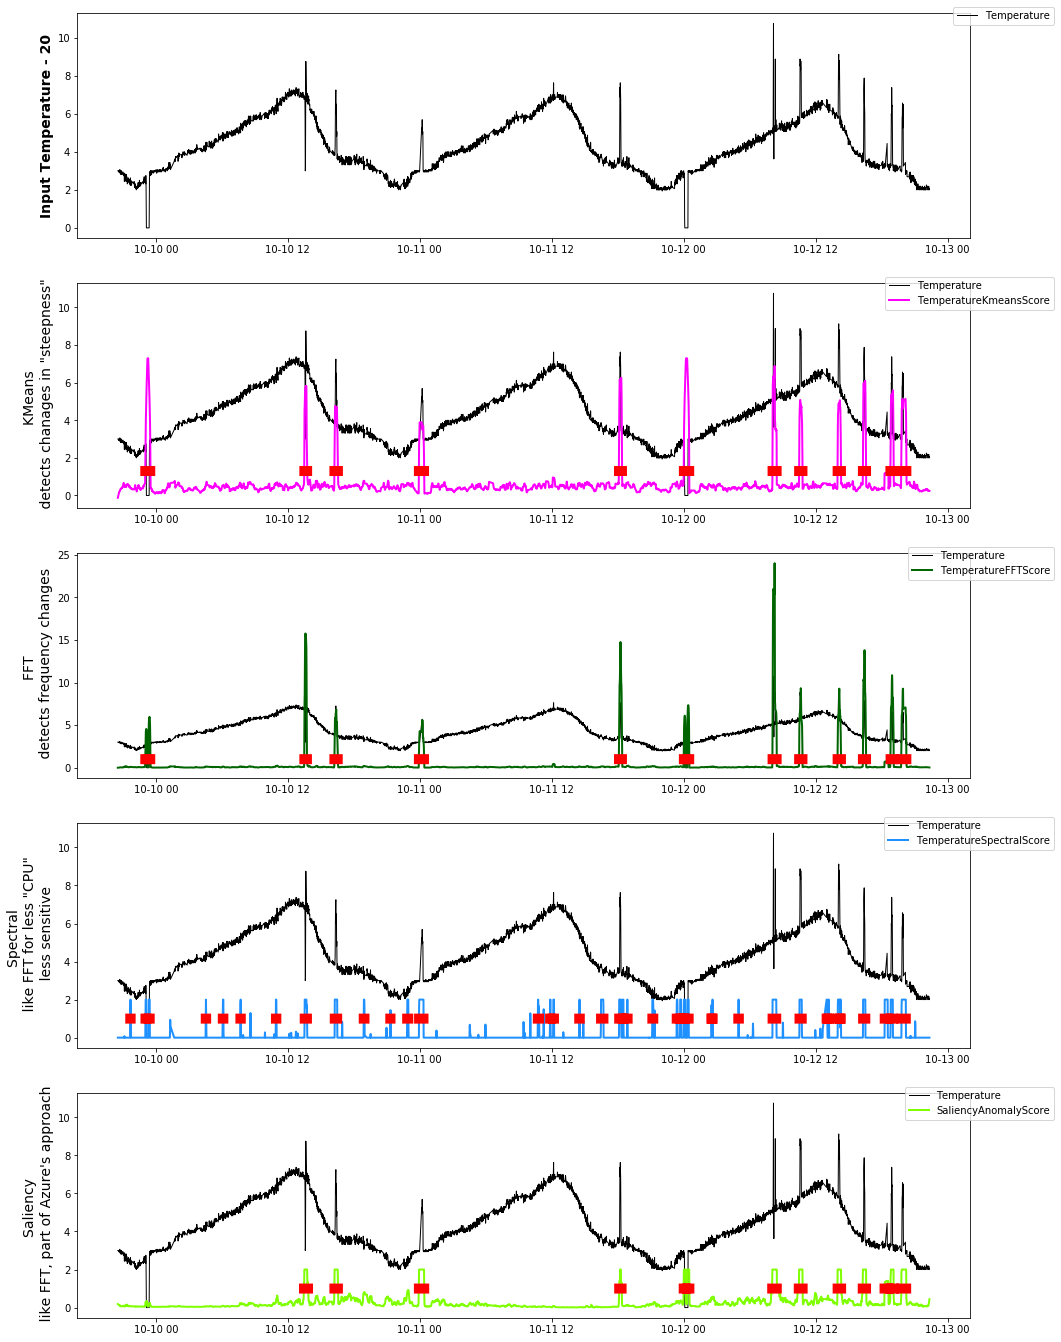

In [6]:
df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
df_input2[spectral].values[df_input2[spectral] < -40] = -40
df_input2[sal].values[df_input2[sal] > 200] = 200



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = -df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < 20] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > 20] = 20
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < 100] = np.nan
df_input2[salA].values[df_input2[salA] > 100] = 100
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break


fig, ax = plt.subplots(5, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_input2.index, -df_input2[spectral]/40, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_input2.index, df_input2[sal]/100, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=14)
cnt = 2
ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=14)
cnt = 3
ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, -df_input2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=14)
cnt = 4
ax[cnt].plot(df_input2.index, df_input2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[sal]/100, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_input2.index, df_input2[salA]/100, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=14)


#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight


In [7]:
# Now we proceed to customer data

# Get stuff in
df_input = pd.read_csv('./TemperatureAnomalyScore.csv', index_col=False, parse_dates=['timestamp'])
df_input['entity']=df_input['deviceid']

# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')
df_input = df_input.set_index(['entity','timestamp']).dropna()

df_input.head(5)

deviceid  TemperatureKmeansScore  \
entity       timestamp                                                   
04714B60011A 2020-01-19 20:12:00  04714B60011A                0.662106   
             2020-01-19 20:17:00  04714B60011A                0.588443   
             2020-01-19 20:22:00  04714B60011A                0.463848   
             2020-01-19 20:27:00  04714B60011A                0.470927   
             2020-01-19 20:32:00  04714B60011A                0.461369   

                                  TemperatureFFTScore  \
entity       timestamp                                  
04714B60011A 2020-01-19 20:12:00           113.734897   
             2020-01-19 20:17:00           139.645283   
             2020-01-19 20:22:00            83.847681   
             2020-01-19 20:27:00            29.712756   
             2020-01-19 20:32:00            67.705654   

                                  TemperatureSpectralScore  \
entity       timestamp                                       
04714B60011A 2020-01-19 20:12:00                  3.604408   
             2020-01-19 20:17:00                  3.816970   
             2020-01-19 20:22:00                  4.366504   
             2020-01-19 20:27:00                  3.785085   
             2020-01-19 20:32:00                  3.024307   

                                  TemperatureGeneralizedScore  Temperature  
entity       timestamp                                                      
04714B60011A 2020-01-19 20:12:00                 13443.170501         49.7  
             2020-01-19 20:17:00                 82443.617056         49.2  
             2020-01-19 20:22:00                 13483.285199         49.4  
             2020-01-19 20:27:00                  3444.312578         49.5  
             2020-01-19 20:32:00                 13519.768573         49.3

In [8]:
salii = SaliencybasedGeneralizedAnomalyScore('Temperature', 12, 'SaliencyAnomalyScore')
et = salii._build_entity_type(columns = [Column('Temperature',Float())])
salii._entity_type = et
df_input = salii.execute(df=df_input)


spsii = SpectralAnomalyScore('Temperature', 12, 'TemperatureSpectralScore')
et = spsii._build_entity_type(columns = [Column('Temperature',Float())])
spsii._entity_type = et
df_input = spsii.execute(df=df_input)

df_input.describe()

2020-01-23T12:57:40.639 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-23T12:57:40.640 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-23T12:57:40.741 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-23T12:57:40.742 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,TemperatureKmeansScore,TemperatureFFTScore,TemperatureSpectralScore,TemperatureGeneralizedScore,Temperature,SaliencyAnomalyScore
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,0.692756,56.101477,4.860005,13102.448573,51.436299,24.753927
std,0.239781,80.347290,7.718240,21898.649505,2.811310,24.851377
min,0.258147,-557.021815,-47.010879,-368.306560,47.600000,2.437760
25%,0.526260,19.507591,4.320218,1047.669645,49.200000,6.120701
50%,0.656372,38.523352,6.424799,5101.256203,50.500000,18.763793
75%,0.827491,74.428770,7.512875,13519.768573,53.800000,31.244788
max,1.756310,662.430503,45.520282,143094.954952,56.600000,131.873152


In [9]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B60011A']]
df_input2.reset_index(level=[0], inplace=True)

Text(0, 0.5, 'Generalized \n more (too ?) sensitive')

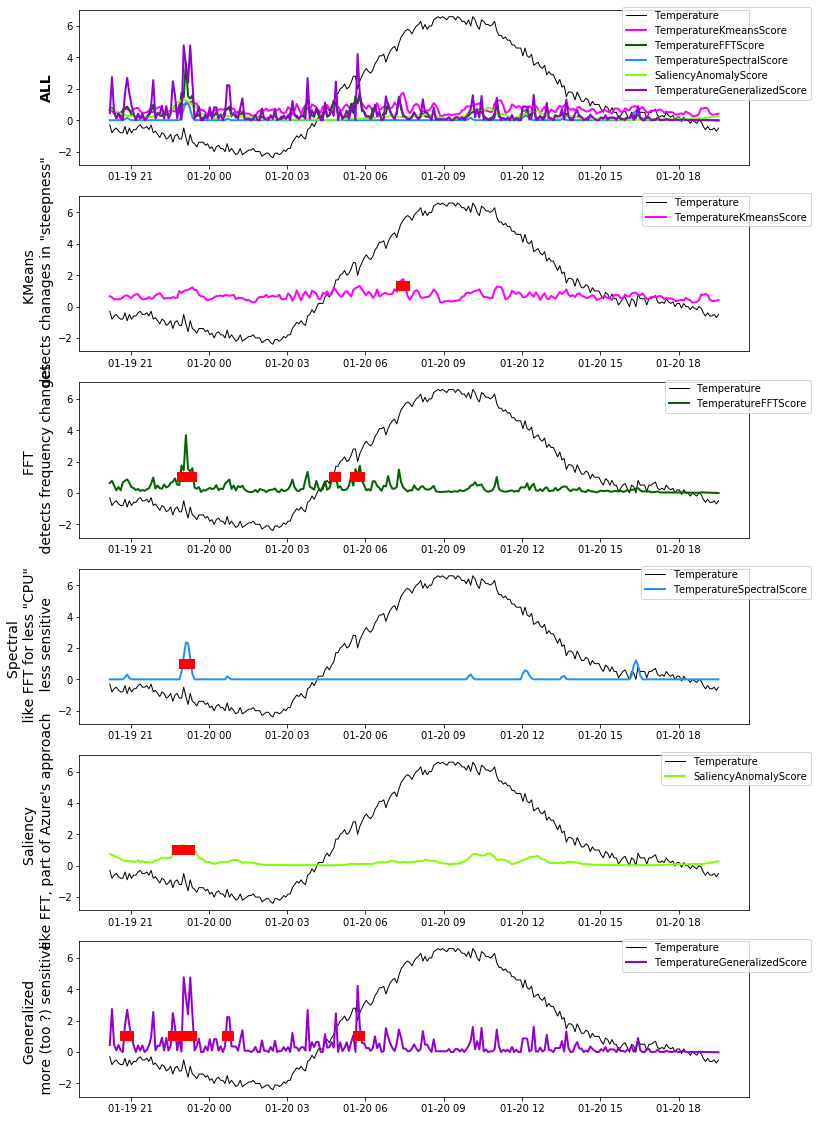

In [11]:
df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = -df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < 20] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > 20] = 20
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < 100] = np.nan
df_input2[salA].values[df_input2[salA] > 100] = 100
df_input2[genA] = df_input2[gen]
df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
df_input2[genA].values[df_input2[genA] > gen_break] = gen_break


fig, ax = plt.subplots(6, 1, figsize=(12,20))
ax[0].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[0].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[0].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[0].plot(df_input2.index, -df_input2[spectral]/40, linewidth=2,color='dodgerblue', label=spectral)
ax[0].plot(df_input2.index, df_input2[sal]/100, linewidth=2,color='chartreuse',label=sal)
ax[0].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[0].legend(bbox_to_anchor=(1.1, 1.05))
ax[0].set_ylabel('ALL',fontsize=14,weight="bold")

ax[1].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[1].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[1].plot(df_input2.index, df_input2[kmeansB], linewidth=2, color='yellow') #label=kmeans)
ax[1].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
ax[1].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=14)

ax[2].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[2].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[2].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[2].legend(bbox_to_anchor=(1.1, 1.05))
ax[2].set_ylabel('FFT \n detects frequency changes', fontsize=14)

ax[3].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[3].plot(df_input2.index, -df_input2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[3].plot(df_input2.index, df_input2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[3].legend(bbox_to_anchor=(1.1, 1.05))
ax[3].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=14)

ax[4].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[4].plot(df_input2.index, df_input2[sal]/100, linewidth=2,color='chartreuse', label=sal)
ax[4].plot(df_input2.index, df_input2[salA]/100, linewidth=10, color='red') #,label=kmeansA)
ax[4].legend(bbox_to_anchor=(1.1, 1.05))
ax[4].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=14)

ax[5].plot(df_input2.index, df_input2[Temperature]-50,linewidth=1,color='black',label=Temperature)
ax[5].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
ax[5].plot(df_input2.index, df_input2[genA]/gen_break, linewidth=10, color='red')
ax[5].legend(bbox_to_anchor=(1.1, 1.05))
ax[5].set_ylabel('Generalized \n more (too ?) sensitive', fontsize=14)


#ax.set_ylabel('Temperature-50')

### Results

FFT, Spectral, Saliency and Generalized detect an anomaly after midnight while KMeans spots one at ~8:00 am.

| Detector | How does it work |
| ------- | ---------------- |
| KMeans   | Spots "steep line" anomaly at roughly 8am, nothing else |
| FFT | Spots "high signal energy" anomaly after midnight, "steep line" at 4 and "peak" shortly before 6am |
| Spectral | Spots "high signal energy" anomaly after midnight |
| Saliency | Spots "high signal energy" anomaly after midnight, less "pronounced" anomaly scores -> less useful |
| Generalized | Spots "high signal energy" anomaly after midnight and "peak" shortly before 6am, couple of false alerts |
| SimpleAnomaly| We don't have SimpleAnomaly running yet: we can only train on entity input data right now, not on pipeline generated data. |

### Conclusion

**There is no one size fits all.**

Without prior knowledge I'd apply KMeans and FFT as basic unsupervised anomaly detectors

### Next steps

#### Improving unsupervised methods

* Get the scales right
  current anomaly functions vary wildly in scale (KMeans between 0,2, Spectral from -infinity to 0 ...)
* Data Cleansing stage is missing

* Longer term: Follow microsoft's approach
  - Get the anomaly generator working as part of the pipeline
  - Generate randomized timeseries data with known anomalies
  - Slice it and label the slices by anomaly type (None, Near vertical line, flat line, ...)
  - Train a plain CNN on generated anomalies and apply it to real data

#### Supervised methods

* Lift the restriction that SimpleAnomaly can only train on raw input data
